In [1]:
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480


import matplotlib.pyplot as plt
import math
from PIL import Image

import scipy.fftpack as sfft
import random
import sys
from pylab import *
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import label, center_of_mass
import cv2
import tifffile
from scipy.spatial import ConvexHull
### 1920 x 1200 SLM

In [2]:
precision = 1 ### Multiplier to get better tunability


In [3]:
### Create diffraction grating
blank = np.empty((1920*precision,1200*precision),dtype=float)
grating = blank.copy()
width_pix = 8 ### choose this to be over 8, ideally
length_pix = 8 ### choose this to be over 8, ideally
numcols = np.size(grating[0])  ## should be 1920
numrows = np.size(grating[...,0])  ## should be 1200
max_iter = 30 ### for GS algo

### Settings for image generation
numframes = 30 # set number of frames in movie
min_width_pix = 8
min_length_pix = 8
stepsize_width_pix = 1 # must be integer
stepsize_length_pix = 1 # must be integer


def Ger_Sax_algo(InputImg, width, height, max_iter):
    TwoDImg = np.reshape(InputImg, (-1, width))

    pm_s = np.random.rand(height, width)
    pm_f = np.ones((height, width))
    am_s = np.sqrt(TwoDImg) / 2
    am_f = np.ones((height, width))

    signal_s = am_s*np.exp(pm_s * 1j)

    for iter in range(max_iter):
        signal_f = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(signal_s)))
        pm_f = np.angle(signal_f)
        signal_f = am_f*np.exp(pm_f * 1j)
        signal_s = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(signal_f)))
        pm_s = np.angle(signal_s)
        signal_s = am_s*np.exp(pm_s * 1j)

    phase_mask = np.uint8(((pm_f/(2*np.pi))*256)+128)
    ### flat_phase = phase_mask.flatten()

    return phase_mask

### SLM Direct Images
# Create an SLM grating with sinusoidal pixel values

def gen_tweezers(xrad, yrad, xspacing, yspacing, xmin, xmax, ymin,ymax):
    simplegrating = np.zeros(np.shape(blank))

    for i in range(xmin,xmax):
        for j in range(ymin,ymax):
            pixcoord = 0
            distj1 = j  % yspacing
            disti1 = i  % xspacing
            distj2 = (yspacing - j) % yspacing
            disti2 = (xspacing - i) % xspacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating


def gaussian_distribution(x, radius):
    return np.exp(-0.5 * (x / radius)**2)

def gen_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend):
    simplegrating = np.zeros(np.shape(blank))
    
    for i in range(xstart, xend):
        for j in range(ystart,yend):
            pixcoord = 0
            distj1 = (j - ystart)  % yspacing
            disti1 = (i - xstart) % xspacing
            distj2 = (yspacing - (j-ystart)) % yspacing
            disti2 = (xspacing - (i-xstart)) % xspacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating

def gaussian_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend, radius):
    tweezers = gen_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend)
    gaussiantweezers = tweezers
    binary_camera_image = (tweezers > 2).astype(np.uint8)
    labeled_camera_image, num_labels_camera = label(binary_camera_image)
    centers_camera = np.array(center_of_mass(binary_camera_image, labeled_camera_image, range(1, num_labels_camera + 1)))
    ## Capture 99.7% of the distribution
    factor = 3
    for i in range(len(centers_camera)):
        for x in range(-radius, radius,1):
            for y in range(-radius, radius,1):
                
                radvalue = (x**2+y**2)**0.5
                if radvalue < radius:
                    gaussiantweezers[centers_camera[i][0].astype(np.int) + x, centers_camera[i][1].astype(np.int) + y] += 255*gaussian_distribution(radvalue * 3, radius)
    
    return gaussiantweezers

def gen_circlemask(radius):
    simplegrating = np.zeros(np.shape(blank))
    for i in range(1920 * precision):
        for j in range(1200 * precision):
            pixcoord = 0
            if (((1920 * precision)/2 - i)**2 + ((1200 * precision)/2 - j)**2)**0.5 < radius:
                pixcoord = 255
            simplegrating[i,j] = pixcoord
    return simplegrating


### Image writing!

def f_grating(pattern):
    return Ger_Sax_algo(pattern, numcols, numrows, max_iter)

def writeimg(array, name):
    data = Image.fromarray(array).convert('RGB')
    data.save(name+".bmp")
    return print(name+" saved succesfully.")

def print_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        writeimg(array, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        writeimg(array, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")

def print_f_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_f_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")


def slm_2D_simulator(function, maxiter, min_width_pix, min_length_pix):
    slmarray = function(min_width_pix, min_length_pix)
    slmimage = Ger_Sax_algo(slmarray, numcols, numrows, maxiter)
    fourierimage = np.abs(np.fft.fft2(slmimage))
    fourierimage = fourierimage/np.max(fourierimage)*255
    writeimg(fourierimage,"simulim")
    return print("Print successful")


In [13]:
### Optimization code
### Testing Ger-Sax algorithm

def epsilon(u_int, target_im):
    max = np.max(u_int[target_im==1]) #Max value of the obtained intensity at the tweezers position
    min = np.min(u_int[target_im==1]) #Min value of the obtained intensity at the tweezers position
    error = (max-min)/(max+min)
    
    # error = np.sum(np.abs(u_int-target_im))
    #print("Error :", error)
    return error

def join_phase_ampl(phase,ampl):
    tmp=np.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = ampl*np.exp(phase*1j)
    return tmp

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

def norm(matrix):
    min=np.min(matrix);max=np.max(matrix)
    return((matrix-min)/(max-min))

def bin_norm_clip(matrix):  # Function that clips the values to 0-255 (SLM standard)
    matrix=np.array(target_im, dtype=np.uint8)
    matrix=norm(matrix)
    return(matrix)


def screwone(list):
    for number in list:
        if number == 1:
            number = number - 0.01
    return number

def weights(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    # targetmatch_indices = np.argwhere(target_im==1)
    # for i in targetmatch_indices:
    #     for x in range(-2,3):
    #         for y in range(-2,3):
    #             w[i[0]+x,i[1]+y] = np.sqrt((target_im[i[0]+x,i[1]+y] / std_int[i[0]+x,i[1]+y])) *w_prev[i[0]+x,i[1]+y]
    #             # w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]
    w[target_im==1] = np.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)


def discretize_phase(phase):
    phase=np.round((phase+np.pi)*255/(2*np.pi))
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*np.pi)-np.pi
    return(phase)

def set_circlemask(inputmatrix, radius):
    copy = inputmatrix
    for i in range(1920):
        for j in range(1200):
            pixcoord = inputmatrix[i,j]
            if (((1920)/2 - i)**2 + ((1200)/2 - j)**2)**0.5 > radius:
                pixcoord = 0
            copy[i,j] = pixcoord
    return copy



In [14]:

def identify_tweezers(cameraimage, minintensity):
    ## This code assumes that the camera image is positioned s.t. the 0th order diffraction is centered vertically and just out of screen
    binary_camera_image = (cameraimage > minintensity).astype(np.uint8)
    labeled_camera_image, num_labels_camera = label(binary_camera_image)
    centers_camera = np.array(center_of_mass(binary_camera_image, labeled_camera_image, range(1, num_labels_camera + 1)))
    sorted_centers = centers_camera[np.lexsort((centers_camera[:, 1], centers_camera[:, 0]))]


    center = np.median(sorted_centers, axis=0)
    distances = np.linalg.norm(sorted_centers - center, axis=1)
    indices = np.argsort(distances)[-4:]
    corners = sorted_centers[indices]
    
    # perimeter = ConvexHull(sorted_centers) 
    # corners = sorted_centers[perimeter.vertices]
    return corners[np.argsort(corners[:,0])], center

from scipy.ndimage import affine_transform

def rotate_image(image, angle):
    # Calculate the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])

    # Calculate the translation needed to reposition the rotated image
    center = np.array(image.shape) // 2
    translation = center - np.dot(rotation_matrix, center)

    # Define the affine transformation matrix
    transformation_matrix = np.vstack([np.column_stack([rotation_matrix, translation]),
                                       [0, 0, 1]])

    # Apply the affine transformation to rotate the image
    rotated_image = affine_transform(image, transformation_matrix, mode='constant', cval=0)

    return rotated_image

from scipy.ndimage import zoom

def match_images(cameraimage, targetimage, intensity):
    camera_vertices = identify_tweezers(cameraimage, intensity)[0]
    angle = math.atan((camera_vertices[1,0]-camera_vertices[0,0])/(camera_vertices[1,1]-camera_vertices[0,1]))
    rotated_cameraimage = rotate_image(cameraimage, -angle)
    rotated_cameraimage_vertices = identify_tweezers(rotated_cameraimage, intensity)[0]
    targetimage_vertices, targetimage_center = identify_tweezers(targetimage, 1)

    height_target_rect = np.abs(targetimage_vertices[0,0] - targetimage_vertices[2,0])
    width_target_rect = np.abs(targetimage_vertices[0,1] - targetimage_vertices[1,1])
    height_camera_rect = np.abs(rotated_cameraimage_vertices[0,0] - rotated_cameraimage_vertices[2,0])
    width_camera_rect = np.abs(rotated_cameraimage_vertices[0,1] - rotated_cameraimage_vertices[1,1])

    height_scaling = height_target_rect / height_camera_rect
    width_scaling = width_target_rect / width_camera_rect
 
    scaled_camera_img = zoom(rotated_cameraimage, (height_scaling,width_scaling), mode='constant', cval = 0)
    scaled_camera_img_vertices, scaled_camera_center = identify_tweezers(scaled_camera_img, intensity)
 
    
    final_camera_img = np.zeros_like(targetimage)
    
    for y in range(np.shape(scaled_camera_img)[0]):
        for x in range(np.shape(scaled_camera_img)[1]):
            final_camera_img[y+(targetimage_center[0]-scaled_camera_center[0]).astype(np.int),x+(targetimage_center[1]-scaled_camera_center[1]).astype(np.int)] = scaled_camera_img[y,x]
    return final_camera_img, -angle, height_scaling, width_scaling, (targetimage_center[0]-scaled_camera_center[0]).astype(np.int), (targetimage_center[1]-scaled_camera_center[1]).astype(np.int)


def match_images_local(cameraimage, targetimage, params, scanradius):
    cameraimage = cameraimage
    targetimage = targetimage
    angle, Xmag, Ymag, Xshift, Yshift = params
    slave9 = rotate_image(cameraimage, angle)
    slave8 = scaleimg(slave9, Xmag, Ymag)
    master = np.zeros(np.shape(targetimage))
    original = shiftimage(slave8, targetimage, Xshift, Yshift)
    error = np.abs(np.sum(targetimage-original))
    for i in range(scanradius):
        for j in range(scanradius):
            slave_shifted = shiftimage(slave8, targetimage, Xshift - scanradius/2 + i, Yshift - scanradius/2 +j)
            errortemp = np.abs(np.sum(slave_shifted-targetimage))
            if errortemp < error:
                error = errortemp
                master = slave_shifted
    if np.sum(master) == 0:
        return original
    else:
        return master



def shiftimage(child1, parent, x_shift, y_shift):
    child_shape = np.shape(child1)
    parent_shape = np.shape(parent)
    fosterparent = np.zeros(parent_shape)
    x_shift = x_shift.astype(np.int)
    y_shift = y_shift.astype(np.int)
    fosterparent[x_shift:x_shift+child_shape[0], y_shift:y_shift+child_shape[1]] = child1
    return fosterparent

def scaleimg(child2, x_scaling, y_scaling):
    scaled_child = zoom(child2, (x_scaling, y_scaling), mode='constant', cval = 0)
    return scaled_child

    
    
def objectivefunction(params, child, parent):
    angle, Xmag, Ymag, Xshift, Yshift = params
    slave = rotate_image(child, angle)
    slave = scaleimg(slave, Xmag, Ymag)
    slave = shiftimage(slave, parent, Xshift, Yshift)
    
    error = np.abs(np.sum(slave-parent))
    return error


def find_weighted_center(image):
    # Create coordinate grids
    image = norm(image)
    image[image<0.3] = 0
    
    non_zero_coords = np.transpose(np.nonzero(image))
    if non_zero_coords.shape[0] > 0:
        average_coordinates = np.mean(non_zero_coords, axis=0)
        return tuple(average_coordinates.astype(int))
    else:
        return None


from PIL import Image

def tiff_to_bmp(input_path, output_path):
    # Open TIFF image
    tiff_image = Image.open(input_path)

    # Save as BMP
    tiff_image.save(output_path, 'BMP')
    
    
import cv2
import numpy as np

def match_and_paste(parent, child):
    # Convert images to grayscale
    parent_gray = cv2.cvtColor(parent, cv2.COLOR_BGR2GRAY)
    child_gray = cv2.cvtColor(child, cv2.COLOR_BGR2GRAY)

    # Use ORB (Oriented FAST and Rotated BRIEF) to find keypoints and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(parent_gray, None)
    kp2, des2 = orb.detectAndCompute(child_gray, None)

    # Use BFMatcher to find the best matches between the descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort the matches based on their distances
    matches = sorted(matches, key=lambda x: x.distance)

    # Get the best match
    best_match = matches[0]

    # Get the keypoint coordinates for the parent and child
    parent_pts = np.float32([kp1[best_match.queryIdx].pt])
    child_pts = np.float32([kp2[best_match.trainIdx].pt])

    # Find the transformation matrix (rotation and scaling)
    M, _ = cv2.estimateAffinePartial2D(child_pts, parent_pts)

    # Apply the transformation to the child image
    child_transformed = cv2.warpAffine(child, M, (parent.shape[0], parent.shape[1]))

    return child_transformed




In [15]:
def identify_corners(cameraimage, targetimage, intensity):
    camera_vertices = identify_tweezers(cameraimage, intensity)[0]
    angle = math.atan((camera_vertices[1,0]-camera_vertices[0,0])/(camera_vertices[1,1]-camera_vertices[0,1]))
    rotated_cameraimage = rotate_image(cameraimage, -angle)
    rotated_cameraimage_vertices = identify_tweezers(rotated_cameraimage, intensity)[0]
    targetimage_vertices, targetimage_center = identify_tweezers(targetimage, 1)

    height_target_rect = np.abs(targetimage_vertices[0,0] - targetimage_vertices[2,0])
    width_target_rect = np.abs(targetimage_vertices[0,1] - targetimage_vertices[1,1])
    height_camera_rect = np.abs(rotated_cameraimage_vertices[0,0] - rotated_cameraimage_vertices[2,0])
    width_camera_rect = np.abs(rotated_cameraimage_vertices[0,1] - rotated_cameraimage_vertices[1,1])

    height_scaling = height_target_rect / height_camera_rect
    width_scaling = width_target_rect / width_camera_rect
 
    scaled_camera_img = zoom(rotated_cameraimage, (height_scaling,width_scaling), mode='constant', cval = 0)
    scaled_camera_img_vertices, scaled_camera_center = identify_tweezers(scaled_camera_img, intensity)
 
    
    corners_cameraimg = np.zeros_like(targetimage)
    # corners_cameraimg[int(targetimage_vertices[0,0]), int(targetimage_vertices[0,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[1,0]), int(targetimage_vertices[1,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[2,0]),int(targetimage_vertices[2,1])] = 255
    # corners_cameraimg[int(targetimage_vertices[3,0]),int(targetimage_vertices[3,1])] = 255
    corners_cameraimg[targetimage_vertices[0,0].astype(np.int), targetimage_vertices[0,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[1,0].astype(np.int), targetimage_vertices[1,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[2,0].astype(np.int),targetimage_vertices[2,1].astype(np.int)] = 255
    corners_cameraimg[targetimage_vertices[3,0].astype(np.int),targetimage_vertices[3,1].astype(np.int)] = 255
    return corners_cameraimg, -angle, height_scaling, width_scaling, (targetimage_center[0]-scaled_camera_center[0]).astype(np.int), (targetimage_center[1]-scaled_camera_center[1]).astype(np.int)

In [16]:
# target_formatching = np.asarray(Image.open("precision1spacing15off0_0.bmp"))
# precision = 1
# target_formatching_numpy = np.zeros((1200*precision,1920*precision))

# for i in range(1920*precision):
#   for j in range(1200*precision):
#       target_formatching_numpy[1200*precision - j -1, 1920*precision - i -1] = 0
#       if target_formatching[1920*precision - i -1, 1200*precision - j -1,1] > 0.1:
#         target_formatching_numpy[j,i] = 255
        
# camera_test = tifffile.imread("imgprecision1spacing15off00.tif")
# camera_output = camera_test[:,:,0]


# test, angle, Xmag, Ymag, Xshift, Yshift = match_images(camera_output[50:1000,200:1200], target_formatching_numpy, 40)

# plt.imshow(-test[500:650, 900:1300]+target_formatching_numpy[500:650, 900:1300])

In [19]:
########### IF CRASH, ONLY RUN THIS AND SKIP
# SKIP IF CRASH
# SKIP YOU FOOL THIS COSTS 5 LIFE MINTUES
# CREATE INITIAL FILES HERE
imgname = "gaussian1spacing20off0_0beamtest"

In [20]:
# For 60 by 60
# arr1 = gen_tweezers_precise(1,1, int(precision*10 * 1200/1920), precision*10, int(precision*1200/32*11)+0, int(precision*1200/32*21)+0, int(precision*1920/32*4.5)+0, int(precision*1920/32*14.5)+0)

arr1 = gaussian_tweezers_precise(1,1, int(precision*20 * 1200/1920), precision*20, int(precision*1200/32*15)+0, int(precision*1200/32*17)+0, int(precision*1920/32*11)+0, int(precision*1920/32*13)+0, radius = 3)


target = writeimg(arr1, f"{imgname}")

target_im = np.asarray(Image.open(f"{imgname}.bmp"))
newtar = np.zeros((1920*precision,1200*precision))

for i in range(1920*precision):
  for j in range(1200*precision):
      newtar[i,j] = 0
      if target_im[i,j,1] > 0.1:
        newtar[i,j] = 1
target_im = newtar

C:\Users\songo\AppData\Local\Temp\ipykernel_23140\3805164751.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gaussiantweezers[centers_camera[i][0].astype(np.int) + x, centers_camera[i][1].astype(np.int) + y] += 255*gaussian_distribution(radvalue * 3, radius)


gaussian1spacing20off0_0beamtest saved succesfully.


In [18]:
loaded_data = np.load(f"netarray_{imgname}.npz")
phase = loaded_data['array1']
PS_shape = loaded_data['array2']
w_prev = loaded_data['array3']
w = loaded_data['array4']

anchors_loaded_data = np.load(f"anchors_netarray_{imgname}.npz")
anchors_phase = anchors_loaded_data['array1']
anchors_PS_shape = anchors_loaded_data['array2']
anchors_w_prev = anchors_loaded_data['array3']
anchors_w = anchors_loaded_data['array4']

In [ ]:
def Beam_shape(sizex,sizey,sigma,mu):
    x, y = np.meshgrid(np.linspace(-1,1,sizex), np.linspace(-1,1,sizey))
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return g

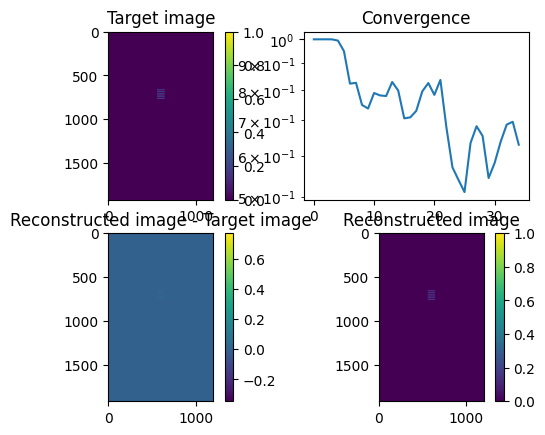

fgaussian1spacing20off0_0 saved succesfully.


In [52]:

SIZE_X, SIZE_Y = 1920, 1200
fig, axs = plt.subplots(2,2)
im0=axs[0,0].imshow(target_im)
plt.colorbar(im0,ax=axs[0,0])
axs[0,0].set_title('Target image')


# The initial weights are all = 1.
n_rep =35
w=np.ones((SIZE_X*precision,SIZE_Y*precision))
# The amplitude in the fourier plane is a Gaussian (beam)
### radius
radiusinput = 650
PS_shape=Beam_shape(SIZE_X,SIZE_Y,255,0)
w_prev=target_im

errors=[]
u=np.zeros((SIZE_X,SIZE_Y),dtype=complex)
phase=2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi

for rep in range(n_rep):
    # Fourier plane, random phase (at the round 1) and gaussian beam
    u=set_circlemask(join_phase_ampl(phase,PS_shape.T), radiusinput)
        # To the real plane...
    u = sfft.fft2(u)
    u = sfft.fftshift(u)
    uscaled = np.repeat(np.repeat(u, precision, axis=0), precision, axis=1)
    # Calculate the intensity
    int=np.square(np.abs(uscaled))
    # Let's renormalize the intensity in the range [0,1]
    std_int=norm(int)
    # What's the distance from the target intensity?
    errors.append(epsilon(std_int, target_im))
    phase=np.angle(uscaled)
    ## Here I don't care about the discretization of the phase because we're in real space (that is actually the fourier plane for the code)
    #Generate weights and use them to obtain u
    w=weights(w,target_im,w_prev,std_int)
    w=norm(w)
    w_prev=w
    uscaled=join_phase_ampl(phase,w)
    # Back to our fourier plane
    reshape_u = uscaled.reshape(1920,precision,1200,precision)
    u = np.mean(reshape_u, axis=(-3,-1))
    u = sfft.ifftshift(u)
    u = sfft.ifft2(u)

    # The phase that we need to imprint by the SLM is :
    phase=np.angle(u)
    # This part discretizes the values of phase. The SLM can only produce values in the range [0,255]
    # that corresponds to [0,2pi]. Some values (e.g. 0.5 => 0.5 * 2pi/255) cannot be reproduced by the SLM
    # This discretization takes that in account. (The final phase will be the discretized one)
    phase=discretize_phase(phase)
    phase = phase
    Final_ampl_phase=phase
    phase=undiscretize_phase(phase)

axs[0,1].plot(errors)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Convergence')


im1=axs[1,0].imshow(target_im-std_int)
plt.colorbar(im1,ax=axs[1,0])
axs[1,0].set_title('Reconstructed image - Target image')

im2=axs[1,1].imshow(std_int)
plt.colorbar(im2,ax=axs[1,1])
axs[1,1].set_title('Reconstructed image')
plt.show()

writeimg(Final_ampl_phase, f"f{imgname}")

img = Image.open(f"f{imgname}.bmp")
img = np.asarray(img)
blank = img[:,:,0]
blank = np.exp(1j * blank * 2 * np.pi / 256)
maxval = np.amax(blank)
f = np.fft.fftshift(np.fft.fft2(blank))
mag_spectrum = np.abs(f)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

img123 = Image.open(f"f{imgname}.bmp")
img123 = np.asarray(img123)
blank123 = img123[:,:,0]
blank123 = np.exp(1j * blank123 * 2 * np.pi / 256)
maxval = np.amax(blank123)
f123 = np.fft.fftshift(np.fft.fft2(blank123))
mag_spectrum = np.abs(f123)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

data123 = Image.fromarray(scaledimg.T).convert('RGB')
data123.save(f"transposed_Simulate_f{imgname}.bmp")

img234 = Image.open(f"f{imgname}.bmp")
transpose = img234.transpose(Image.ROTATE_90)
transpose.save(f"transposed_f{imgname}.bmp")


In [53]:
np.savez_compressed(f"netarray_{imgname}.npz", array1=phase, array2 = PS_shape, array3 = w_prev, array4 = w)

In [54]:
anchors, angle, Xmag, Ymag, Xshift, Yshift = identify_corners(arr1[100:-100,100:-100], arr1, 50)


C:\Users\songo\AppData\Local\Temp\ipykernel_9148\2585506648.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corners_cameraimg[targetimage_vertices[0,0].astype(np.int), targetimage_vertices[0,1].astype(np.int)] = 255
C:\Users\songo\AppData\Local\Temp\ipykernel_9148\2585506648.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

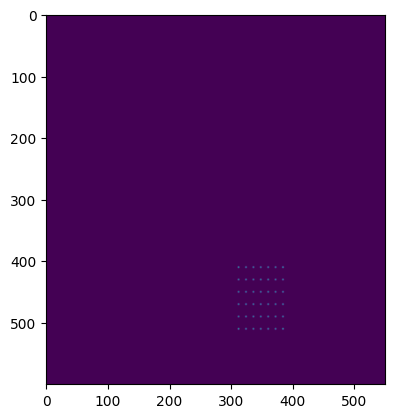

In [55]:
plt.imshow(anchors[250:850, 250:800] + arr1[250:850, 250:800])

In [56]:
### Generate calibration anchor points
# anchors, angle, Xmag, Ymag, Xshift, Yshift = identify_corners(target_im, target_im, 40)
target_anchors = writeimg(anchors, f"anchors_{imgname}")

target_im_anchors = np.asarray(Image.open(f"anchors_{imgname}.bmp"))
newtar = np.zeros((1920*precision,1200*precision))

for i in range(1920*precision):
  for j in range(1200*precision):
      newtar[i,j] = 0
      if target_im_anchors[i,j,1] > 0.1:
        newtar[i,j] = 1
target_im_anchors = newtar

anchors_gaussian1spacing20off0_0 saved succesfully.


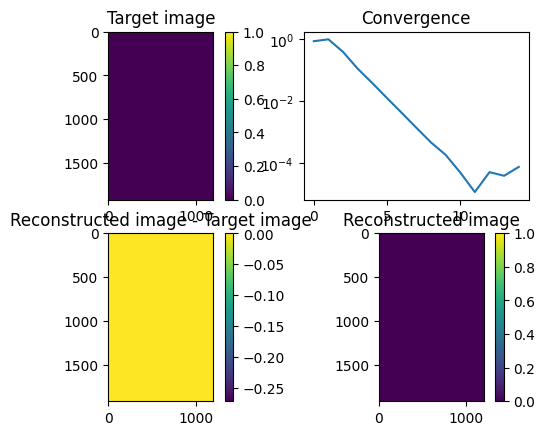

anchors_fgaussian1spacing20off0_0 saved succesfully.


In [57]:

SIZE_X, SIZE_Y = 1920, 1200
fig, axs = plt.subplots(2,2)
im0=axs[0,0].imshow(target_im_anchors)
plt.colorbar(im0,ax=axs[0,0])
axs[0,0].set_title('Target image')


# The initial weights are all = 1.
n_rep =15
w=np.ones((SIZE_X*precision,SIZE_Y*precision))
# The amplitude in the fourier plane is a Gaussian (beam)
### radius
radiusinput = 650
PS_shape=Beam_shape(SIZE_X,SIZE_Y,255,0)
w_prev=target_im_anchors

errors=[]
u=np.zeros((SIZE_X,SIZE_Y),dtype=complex)
phase=2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi

for rep in range(n_rep):
    # Fourier plane, random phase (at the round 1) and gaussian beam
    u=set_circlemask(join_phase_ampl(phase,PS_shape.T), radiusinput)
        # To the real plane...
    u = sfft.fft2(u)
    u = sfft.fftshift(u)
    uscaled = np.repeat(np.repeat(u, precision, axis=0), precision, axis=1)
    # Calculate the intensity
    int=np.square(np.abs(uscaled))
    # Let's renormalize the intensity in the range [0,1]
    std_int=norm(int)
    # What's the distance from the target intensity?
    errors.append(epsilon(std_int, target_im_anchors))
    phase=np.angle(uscaled)
    ## Here I don't care about the discretization of the phase because we're in real space (that is actually the fourier plane for the code)
    #Generate weights and use them to obtain u
    w=weights(w,target_im_anchors,w_prev,std_int)
    w=norm(w)
    w_prev=w
    uscaled=join_phase_ampl(phase,w)
    # Back to our fourier plane
    reshape_u = uscaled.reshape(1920,precision,1200,precision)
    u = np.mean(reshape_u, axis=(-3,-1))
    u = sfft.ifftshift(u)
    u = sfft.ifft2(u)

    # The phase that we need to imprint by the SLM is :
    phase=np.angle(u)
    # This part discretizes the values of phase. The SLM can only produce values in the range [0,255]
    # that corresponds to [0,2pi]. Some values (e.g. 0.5 => 0.5 * 2pi/255) cannot be reproduced by the SLM
    # This discretization takes that in account. (The final phase will be the discretized one)
    phase=discretize_phase(phase)
    phase = phase
    Final_ampl_phase=phase
    phase=undiscretize_phase(phase)

axs[0,1].plot(errors)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Convergence')


im1=axs[1,0].imshow(target_im_anchors-std_int)
plt.colorbar(im1,ax=axs[1,0])
axs[1,0].set_title('Reconstructed image - Target image')

im2=axs[1,1].imshow(std_int)
plt.colorbar(im2,ax=axs[1,1])
axs[1,1].set_title('Reconstructed image')
plt.show()

writeimg(Final_ampl_phase, f"anchors_f{imgname}")

img = Image.open(f"anchors_f{imgname}.bmp")
img = np.asarray(img)
blank = img[:,:,0]
blank = np.exp(1j * blank * 2 * np.pi / 256)
maxval = np.amax(blank)
f = np.fft.fftshift(np.fft.fft2(blank))
mag_spectrum = np.abs(f)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

img123 = Image.open(f"anchors_f{imgname}.bmp")
img123 = np.asarray(img123)
blank123 = img123[:,:,0]
blank123 = np.exp(1j * blank123 * 2 * np.pi / 256)
maxval = np.amax(blank123)
f123 = np.fft.fftshift(np.fft.fft2(blank123))
mag_spectrum = np.abs(f123)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

data123 = Image.fromarray(scaledimg.T).convert('RGB')
data123.save(f"anchors_transposed_Simulate_f{imgname}.bmp")

img234 = Image.open(f"anchors_f{imgname}.bmp")
transpose = img234.transpose(Image.ROTATE_90)
transpose.save(f"anchors_transposed_f{imgname}.bmp")



In [58]:
# save phase, PS_shape, w_prev, w
np.savez_compressed(f"anchors_netarray_{imgname}.npz", array1=phase, array2 = PS_shape, array3 = w_prev, array4 = w)

In [59]:
# FINISH INITIAL CALIBRATIONS
#### 
# ENTER THE LAND OF REALITY

In [60]:
########################################################################################

In [9]:
loaded_data = np.load(f"netarray_{imgname}.npz")
phase = loaded_data['array1']
PS_shape = loaded_data['array2']
w_prev = loaded_data['array3']
w = loaded_data['array4']

anchors_loaded_data = np.load(f"anchors_netarray_{imgname}.npz")
anchors_phase = anchors_loaded_data['array1']
anchors_PS_shape = anchors_loaded_data['array2']
anchors_w_prev = anchors_loaded_data['array3']
anchors_w = anchors_loaded_data['array4']

In [10]:
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS AND DLLS- START %%%%%%%%%%%%%%%%%%%%%%%%%

################################ MAKE SURE THE WINDOW SHOWS UP IN THE WRITE PLACE FOR THE DPI SETTINGS#############
# Query DPI Awareness (Windows 10 and 8)
import ctypes
import os
from ctypes import *
from scipy import misc
from time import sleep
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480



awareness = ctypes.c_int()
errorCode = ctypes.windll.shcore.GetProcessDpiAwareness(0, ctypes.byref(awareness))
print(awareness.value)
# Set DPI Awareness  (Windows 10 and 8)
errorCode = ctypes.windll.shcore.SetProcessDpiAwareness(2)
# the argument is the awareness level, which can be 0, 1 or 2:
# for 1-to-1 pixel control I seem to need it to be non-zero (I'm using level 2)

# Set DPI Awareness  (Windows 7 and Vista)
success = ctypes.windll.user32.SetProcessDPIAware()
# behaviour on later OSes is undefined, although when I run it on my Windows 10 machine, it seems to work with effects identical to SetProcessDpiAwareness(1)
#######################################################################################################################
# Load the DLL
# Blink_C_wrapper.dll, HdmiDisplay.dll, ImageGen.dll, freeglut.dll and glew64.dll
# should all be located in the same directory as the program referencing the
# library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\Blink_C_wrapper")
slm_lib = CDLL("Blink_C_wrapper")

# Open the image generation library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\ImageGen")
image_lib = CDLL("ImageGen")
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS dispup calibration settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# init camera
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])
# Start camera
cam.start_live_video(framerate = "10Hz")

print("Camera Loaded")

RGB = c_uint(1)
is_eight_bit_image = c_uint(0)
NumDataPoints = 10
NumRegions = 1 ## If we need regional calibration, set this to 64
slm_lib.Create_SDK(c_uint(1)) # Initialize SDK, c_unit(1) means true
print("Created SDK")

numFrames = 5
height = c_uint(slm_lib.Get_Height())
width = c_uint(slm_lib.Get_Width())
depth = c_uint(slm_lib.Get_Depth())
center_x = c_uint(width.value//2)
center_y = c_uint(height.value//2)

success = 0
success = slm_lib.Load_lut("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\LUT Files\\19x12_8bit_linearVoltage.lut")
print("Load LUT success")

0
Camera Loaded
Created SDK
Load LUT success


In [11]:
######### SETTINGS

In [12]:
target_formatching = np.asarray(Image.open(f"{imgname}.bmp"))
target_formatching_numpy = np.zeros((1200*precision,1920*precision))

for i in range(1920*precision):
  for j in range(1200*precision):
      target_formatching_numpy[1200*precision - j -1, 1920*precision - i -1] = 0
      if target_formatching[1920*precision - i -1, 1200*precision - j -1,1] > 0.1:
        target_formatching_numpy[j,i] = 255
        
anchors_target_formatching = np.asarray(Image.open(f"anchors_{imgname}.bmp"))
anchors_target_formatching_numpy = np.zeros((1200*precision,1920*precision))

for i in range(1920*precision):
  for j in range(1200*precision):
      anchors_target_formatching_numpy[1200*precision - j -1, 1920*precision - i -1] = 0
      if anchors_target_formatching[1920*precision - i -1, 1200*precision - j -1,1] > 5:
        anchors_target_formatching_numpy[j,i] = 255

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

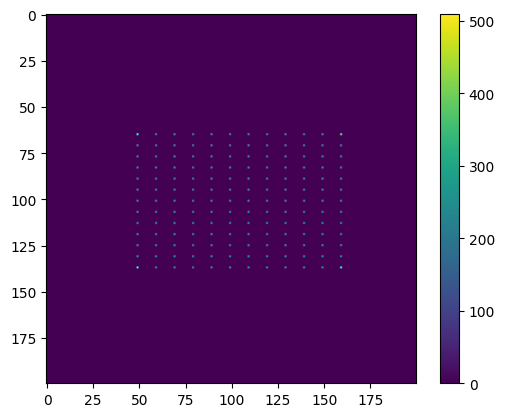

In [ ]:
plt.imshow(anchors_target_formatching_numpy[500:700,1100:1300]+target_formatching_numpy[500:700,1100:1300])
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

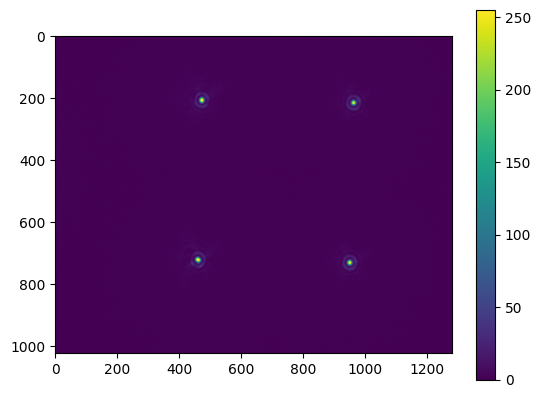

In [ ]:
## NOW SHOW THE ANCHORS
anchors_phase_c = 0
anchors_slminput = 0
anchors_phases_1d = (anchors_phase.T).ravel().astype(np.uint8)
anchors_phases_c = np.empty(anchors_phases_1d.shape, dtype=np.uint8, order='C')
anchors_phases_c[:] = anchors_phases_1d
anchors_slminput = anchors_phases_c
slm_lib.Write_image(anchors_slminput.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
sleep(0.3)       
anchors_camera_test =  cam.grab_image(timeout='100s', copy=True, exposure_time = '2ms')
plt.imshow(anchors_camera_test)
plt.colorbar()
plt.show


1.4663238525390625
255


<function matplotlib.pyplot.show(close=None, block=None)>

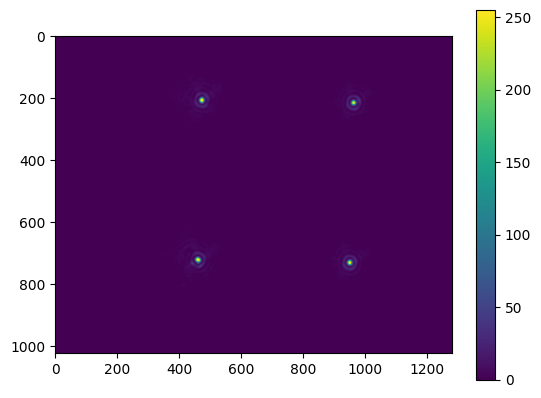

In [33]:
anchors_avg = np.mean(anchors_camera_test)
print(anchors_avg)
print(np.max(anchors_camera_test))
anchors_camera_test_cut = anchors_camera_test
anchors_camera_test_cut[anchors_camera_test_cut < anchors_avg * 2] = 0
plt.imshow(anchors_camera_test_cut)
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

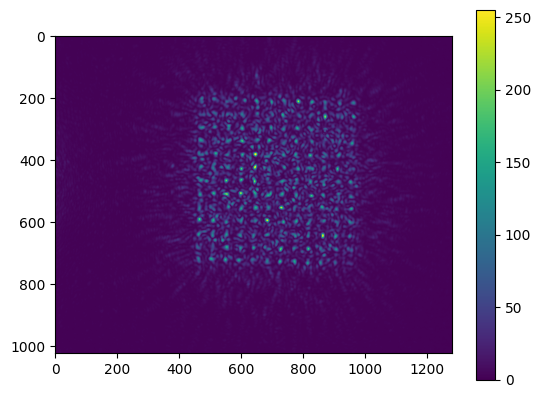

In [34]:
### Grab camera images to find out what sections to use (Remove first order!!)
phases_c = 0
slminput = 0 
phases_1d = (phase.T).ravel().astype(np.uint8)
phases_c = np.empty(phases_1d.shape, dtype=np.uint8, order='C')
phases_c[:] = phases_1d
slminput = phases_c
slm_lib.Write_image(slminput.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
sleep(0.3)       
camera_test =  cam.grab_image(timeout='10s', copy=True, exposure_time = '20ms')
plt.imshow(camera_test)
plt.colorbar()
plt.show


7.912309265136718
255


<function matplotlib.pyplot.show(close=None, block=None)>

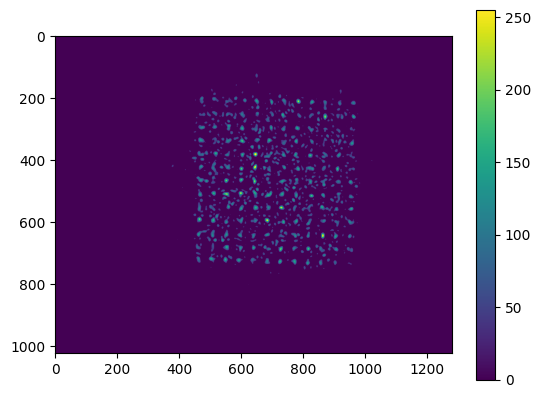

In [35]:
avg = np.mean(camera_test)
print(avg)
print(np.max(camera_test))
camera_test_cut = camera_test
camera_test_cut[camera_test_cut < avg * 5] = 0
plt.imshow(camera_test_cut)
plt.colorbar()
plt.show

In [36]:
# target_im = np.asarray(Image.open(f"{imgname}.bmp"))
# target_formatching_numpy = np.zeros((1200*precision,1920*precision))

# for i in range(1920*precision):
#   for j in range(1200*precision):
#       target_formatching_numpy[1200*precision - j -1, 1920*precision - i -1] = 0
#       if target_im[1920*precision - i -1, 1200*precision - j -1,1] > 0.1:
#         target_formatching_numpy[j,i] = 255

C:\Users\songo\AppData\Local\Temp\ipykernel_5352\1812869818.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  final_camera_img[y+(targetimage_center[0]-scaled_camera_center[0]).astype(np.int),x+(targetimage_center[1]-scaled_camera_center[1]).astype(np.int)] = scaled_camera_img[y,x]
C:\Users\songo\AppData\Local\Temp\ipykernel_5352\1812869818.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, y

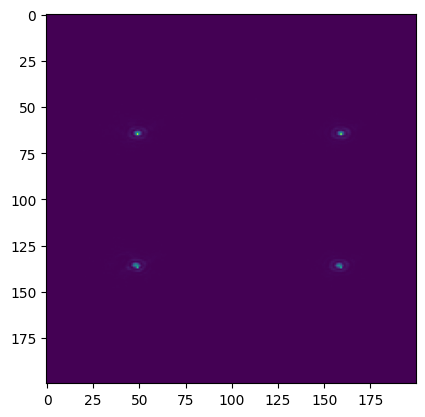

In [43]:

anchors_matched, angle, Xmag, Ymag, Xshift, Yshift = match_images(anchors_camera_test_cut, anchors_target_formatching_numpy,80)

plt.imshow(anchors_matched[500:700,1100:1300] + anchors_target_formatching_numpy[500:700,1100:1300])

In [44]:
params = angle, Xmag, Ymag, Xshift, Yshift
### Test to check local image matching works
localtest = np.zeros(np.shape(anchors_camera_test_cut))
localtest[3:-1,3:-1] = anchors_camera_test_cut[0:-4,0:-4]

result = match_images_local(localtest, anchors_target_formatching_numpy, params, 10)

C:\Users\songo\AppData\Local\Temp\ipykernel_5352\1812869818.py:100: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_shift = x_shift.astype(np.int)
C:\Users\songo\AppData\Local\Temp\ipykernel_5352\1812869818.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note 

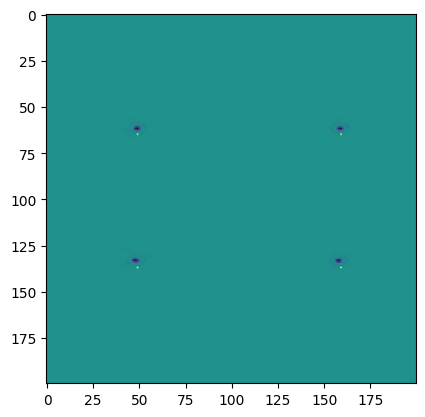

In [42]:
plt.imshow(-result[500:700,1100:1300]+anchors_target_formatching_numpy[500:700,1100:1300])

In [45]:
##### END SETTINGS
target_im = np.asarray(Image.open(f"{imgname}.bmp"))
target_formatching_numpy = np.zeros((1200*precision,1920*precision))

for i in range(1920*precision):
  for j in range(1200*precision):
      target_formatching_numpy[1200*precision - j -1, 1920*precision - i -1] = 0
      if target_im[1920*precision - i -1, 1200*precision - j -1,1] > 0.1:
        target_formatching_numpy[j,i] = 255
target_im = norm(target_im[:,:,0])

In [46]:
params = angle, Xmag, Ymag, Xshift, Yshift

<function matplotlib.pyplot.show(close=None, block=None)>

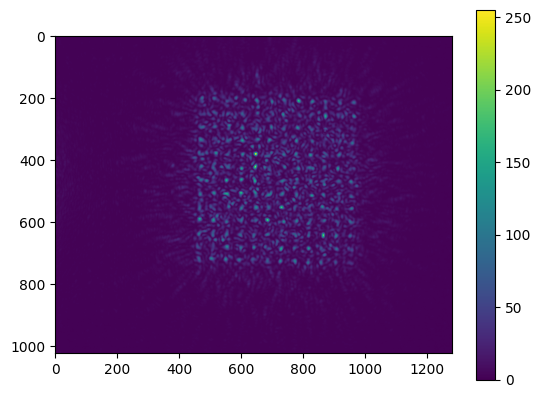

In [47]:
# Verify our camera is nice and peachy
cameraimage = cam.grab_image(timeout='10s', copy=True, exposure_time='15ms')
plt.imshow(cameraimage)
plt.colorbar()
plt.show

In [62]:
cycles = 10

errors = []

for rep in range(cycles):
    # Fourier plane, random phase (at the round 1) and gaussian beam
    radiusinput = 650
    u=set_circlemask(join_phase_ampl(phase,PS_shape.T), radiusinput)
        # To the real plane...
    u = sfft.fftshift(sfft.fft2(u))
    
    
    
    ############################################################################
    ### u -> Camera image now, so feed image into the SLM
    phases_1d = (phase.T).ravel().astype(np.uint8)
    phases_c = np.empty(phases_1d.shape, dtype=np.uint8, order='C')
    phases_c[:] = phases_1d
    slminput = phases_c
    slm_lib.Write_image(phases_c.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
    sleep(0.3)
    cameraimage = cam.grab_image(timeout='10s', copy=True, exposure_time='10ms')
    averagepixel = np.mean(cameraimage)
    croppedcamera = cameraimage
    croppedcamera[croppedcamera < averagepixel] = 0
    cropped_cameraimage = croppedcamera
    matched_image = match_images_local(cropped_cameraimage, target_formatching_numpy, params, 10)
    int = matched_image.T[::-1, ::-1]
    ### Camera image is converted to np array, 
    ##############################################################################
    
    
    # Let's renormalize the intensity in the range [0,1]
    std_int=norm(int)
    # What's the distance from the target intensity?
    errors.append(epsilon(std_int, target_im))
    phase=np.angle(u)
    ## Here I don't care about the discretization of the phase because we're in real space (that is actually the fourier plane for the code)
    #Generate weights and use them to obtain u
    w=weights(w,target_im,w_prev,std_int)
    w=norm(w)
    w_prev=w                                             
    u=join_phase_ampl(phase,w)
    u = sfft.ifftshift(u)
    u = sfft.ifft2(u)

    # The phase that we need to imprint by the SLM is :
    phase=np.angle(u)
    # This part discretizes the values of phase. The SLM can only produce values in the range [0,255]
    # that corresponds to [0,2pi]. Some values (e.g. 0.5 => 0.5 * 2pi/255) cannot be reproduced by the SLM
    # This discretization takes that in account. (The final phase will be the discretized one)
    phase=discretize_phase(phase)
    phase = phase
    Final_ampl_phase=phase
    phase=undiscretize_phase(phase)
    print(rep)
    print(errors[-1])


C:\Users\songo\AppData\Local\Temp\ipykernel_5352\1812869818.py:100: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_shift = x_shift.astype(np.int)
C:\Users\songo\AppData\Local\Temp\ipykernel_5352\1812869818.py:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note 

0
949.9060773480666
1
1526.35
2
1778.6470588235293
3
812.8235294117648
4
763.4444444444443
5
778.5555555555557
6
849.8823529411764
7
830.1176470588234
8
949.5333333333333
9
834.7777777777776


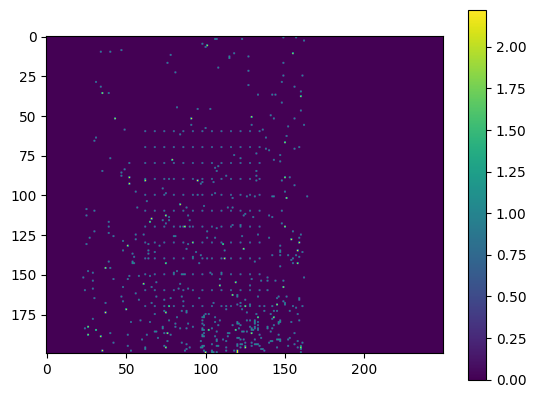

In [65]:
plt.imshow(20*std_int[600:800, 500:750]+target_im[600:800, 500:750])
plt.colorbar()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

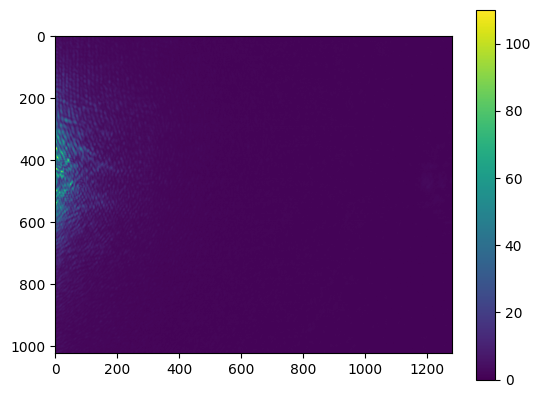

In [68]:
### Grab camera images to find out what sections to use (Remove first order!!) 
testinput = (phase.T).ravel().astype(np.uint8)
testzeros = np.empty(testinput.shape, dtype=np.uint8, order='C')
testzeros[:] = testinput
slm_lib.Write_image(testzeros.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
sleep(0.3)       
camera_test =  cam.grab_image(timeout='10s', copy=True, exposure_time = '60ms')
plt.imshow(camera_test)
plt.colorbar()
plt.show

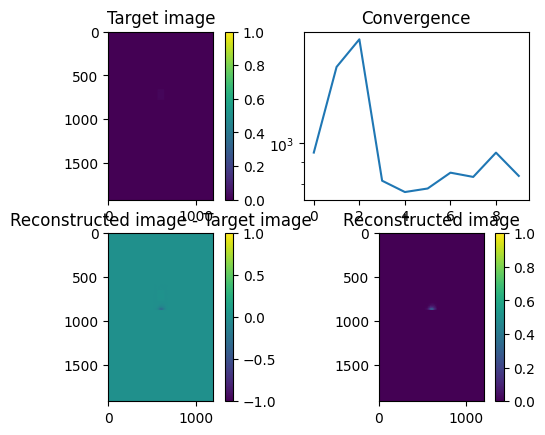

In [69]:
fig, axs = plt.subplots(2,2)
im0=axs[0,0].imshow(target_im)
plt.colorbar(im0,ax=axs[0,0])
axs[0,0].set_title('Target image')

axs[0,1].plot(errors)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Convergence')


im1=axs[1,0].imshow(target_im-std_int)
plt.colorbar(im1,ax=axs[1,0])
axs[1,0].set_title('Reconstructed image - Target image')

im2=axs[1,1].imshow(std_int)
plt.colorbar(im2,ax=axs[1,1])
axs[1,1].set_title('Reconstructed image')
plt.show()

In [76]:
writeimg(Final_ampl_phase, f"f{imgname}imgcorrected")

img = Image.open(f"f{imgname}imgcorrected.bmp")
img = np.asarray(img)
blank = img[:,:,0]
blank = np.exp(1j * blank * 2 * np.pi / 256)
maxval = np.amax(blank)
f = np.fft.fftshift(np.fft.fft2(blank))
mag_spectrum = np.abs(f)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

img123 = Image.open(f"f{imgname}imgcorrected.bmp")
img123 = np.asarray(img123)
blank123 = img123[:,:,0]
blank123 = np.exp(1j * blank123 * 2 * np.pi / 256)
maxval = np.amax(blank123)
f123 = np.fft.fftshift(np.fft.fft2(blank123))
mag_spectrum = np.abs(f123)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

data123 = Image.fromarray(scaledimg.T).convert('RGB')
data123.save(f"transposed_Simulate_f{imgname}imgcorrected.bmp")

img234 = Image.open(f"f{imgname}imgcorrected.bmp")
transpose = img234.transpose(Image.ROTATE_90)
transpose.save(f"transposed_f{imgname}imgcorrected.bmp")

fprecision1spacing10off0_0imgcorrected saved succesfully.


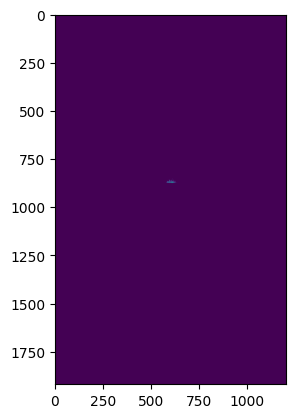

In [58]:
plt.imshow(std_int)